In [1]:
# 相關套件
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import transforms
%matplotlib inline
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from sklearn.linear_model import LinearRegression
import os
import pdb
import math
import pickle

In [2]:
# 相關函數工具

# 灰階直方圖均化 ( 若只有一張圖片 img，則輸入 histogram([img],0) )
def histogram(frames, framenumber):
    frame_hist = frames[framenumber].copy()
    hist,bins = np.histogram(frame_hist.flatten(), 256, [0, 256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')

    frame_hist = cdf[frame_hist]
    
    return frame_hist

# 找可能為物件（指標、刻度、數字）的輪廓
def find_obj_contours(
    raw_frame,
    canny_param1,
    canny_param2):
    # Input image, Canny's param1, param2, Area lower bound, Area upper bound
    
    frame = raw_frame.copy()
    
    # ------- 邊緣偵測 -------
    canny = cv2.Canny(
        frame,
        canny_param1,
        canny_param2)
    
    # ------- 找輪廓 -------
    ( cnts , __ ) = cv2.findContours(
        canny,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)

    # loop over the contours individually
    contour_objs = []
    for idx, c in enumerate(cnts):
        contour_objs.append(c)
    
    return contour_objs

# np 的 gray 轉 rgb
def np_gray2rgb(gray_frame):
    rgb_frame = np.stack((gray_frame,)*3, axis=-1)
    
    return rgb_frame

# 觀察每一張圖片中的輪廓
def observe_each_frame_cnts(frame, cnts):
    # fig = plt.figure(figsize=(10, 10))
    
    frame = np_gray2rgb(frame)
    for each_cnt in cnts:
        cv2.drawContours(
            frame,
            each_cnt, 
            -1, 
            (0, 0, 255),
            1)
        
    # plt.imshow(frame)
    # plt.title('plot cnts.')

    return frame

# 過濾大小
def get_larger_area(cnts, area_lb):
    contour_objs = []
    for idx, c in enumerate(cnts):
        if (cv2.contourArea(c) > area_lb):
            contour_objs.append(c)
    return contour_objs

# 找類似數字的輪廓(為之後使用方便，範圍皆為正方形)
def get_numberlike_contours(frame, cnts):
    num_range = []
    num_contour=[]
    for tar_contour_obj in cnts:
        pts_data = tar_contour_obj.reshape(
            np.shape(tar_contour_obj)[0], 
            np.shape(tar_contour_obj)[2])

        box_min_x = np.min(pts_data[:, 0])
        box_max_x = np.max(pts_data[:, 0])
        box_min_y = np.min(pts_data[:, 1])
        box_max_y = np.max(pts_data[:, 1])

        box_min_x = int(max( box_min_x - (box_max_x - box_min_x) * 0.2, 0 ))
        box_max_x = int(min( box_max_x + (box_max_x - box_min_x) * 0.2, frame.shape[1] ))
        box_min_y = int(max( box_min_y - (box_max_y - box_min_y) * 0.2, 0 ))
        box_max_y = int(min( box_max_y + (box_max_y - box_min_y) * 0.2, frame.shape[0] ))

        # 去掉輪廓為一條鉛錘線或水平線的物件 以及 篩選較高的物件(因為數字是高的)
        if (box_max_y - box_min_y > 0) and (box_max_x - box_min_x > 0) \
                                and ((box_max_y - box_min_y)/(box_max_x - box_min_x) > 1):
            side_len = (box_max_y - box_min_y)/2
            xm = np.mean([box_max_x,box_min_x])
            ym = np.mean([box_max_y,box_min_y])
            
            box_min_x = int(math.ceil(xm - side_len))
            box_max_x = int(math.floor(xm + side_len))
            box_min_y = int(math.ceil(ym - side_len))
            box_max_y = int(math.floor(ym + side_len))

            # 取正方形的範圍，以便之後 train
            if (box_min_x >= 0) and (box_max_x <= frame.shape[1]) and (box_min_y >= 0) and (box_max_y <= frame.shape[0]):
                num_contour.append(tar_contour_obj)
                num_range.append([box_min_x, box_max_x, box_min_y, box_max_y])
                
    return [num_range, num_contour]

# 將鐘面上的數字剪下，分別蒐集成 MNIST 的形態
def meter_database(frame, box_pos, recog_num, hist_flag=True):
    [box_min_x, box_max_x, box_min_y, box_max_y] = box_pos
    num_box = frame[box_min_y:box_max_y, box_min_x:box_max_x].copy()
    
    if hist_flag == True:
        num_box = histogram([num_box], 0)
        
    num_box = 255 - np.array(num_box) # MNIST 是黑底白字
    num_box = cv2.resize(num_box, (28, 28)) # MNIST data 的尺寸\
    
    X = np.array(num_box)
    y = np.array(recog_num).astype('uint8')
    
    return [X, y]

In [ ]:
# 逐張圖片、逐個 box 標記的方法 (有點爛爛的，最後捨棄不用)

### 讀取圖片
img_path = '/home/shared_documents/P2019_LEVELING/Dataset/daily/daily_right/'

pix_data = []
label_data = []

for date_num in np.arange(1, 30):
    for hr_num in np.arange(9, 18):
        
        date_str = '{:02}'.format(date_num)
        hr_str = '{:02}'.format(hr_num)
        
        cand_imgs = [x for x in os.listdir(img_path) 
                     if '201911' + date_str + '_' + hr_str in x]
        tar_img_filename = np.random.choice(cand_imgs, 1)[0]

        img = np.load(os.path.join(img_path, tar_img_filename))
        img_rotated = np.empty([img.shape[1],img.shape[0]])
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                img_rotated[j][i]=img[i][-j]
        img_rotated = img_rotated.astype(np.uint8)
        frames = img_rotated

        # # 畫圖看一下
        # plt.figure(figsize=(10, 10))
        # plt.imshow(frames, cmap='gray')
        # plt.title('raw image')

        # 灰階直方圖均化
        frames_hist = histogram([frames],0)

        # # 畫圖看一下
        # plt.figure(figsize=(10, 10))
        # plt.imshow(frames_hist, cmap='gray')
        # plt.title('histogram image')

        # 找出所有可能的輪廓
        contour_objs = find_obj_contours(frames_hist, canny_param1=100, canny_param2=500)

        # 畫圖看一下
        obs_frame = observe_each_frame_cnts(
            frames_hist,
            contour_objs)

        # 可能的輪廓 - 篩
        nonpt_cnts = get_larger_area(contour_objs, area_lb=100)

        # # 畫圖看一下
        # obs_frame = observe_each_frame_cnts(frames_hist, nonpt_cnts)

        # 找出能圍住數字的框框
        box_pos, num_contour = get_numberlike_contours(frames_hist, nonpt_cnts)

        # 把數字框畫出來看一看
        tar_frame = np_gray2rgb(frames_hist)
        for each_box_pos in box_pos:
            cv2.rectangle(
                tar_frame, 
                (each_box_pos[0], each_box_pos[2]), 
                (each_box_pos[1], each_box_pos[3]),
                (255, 0, 0),
                1)
        plt.figure(figsize=(10, 10))
        plt.imshow(tar_frame)
        plt.title(tar_img_filename)

        # 用 cv 找到的 x,y 位置座標，放到 np 要顛倒變成 y, x
        for each_box_pos in box_pos:
            num_box = frames_hist[
                each_box_pos[2]:each_box_pos[3], 
                each_box_pos[0]:each_box_pos[1]]

            plt.figure(figsize=(2, 2))
            num_box = np_gray2rgb(num_box)

            num_box = 255 - np.array(num_box) # MNIST 是黑底白字
            num_box = cv2.resize(num_box, (28, 28)) # MNIST data 的尺寸

            plt.imshow(num_box)
            plt.show()

            labeling = input('number = ')
            if labeling == 'exit':
                exit(0)
            elif labeling != 'x':
                # plt.savefig('x' + labeling)    # 畫圖
                pix_data.extend(num_box)
                label_data.append(int(labeling))
            else:
                print('Pass')
    

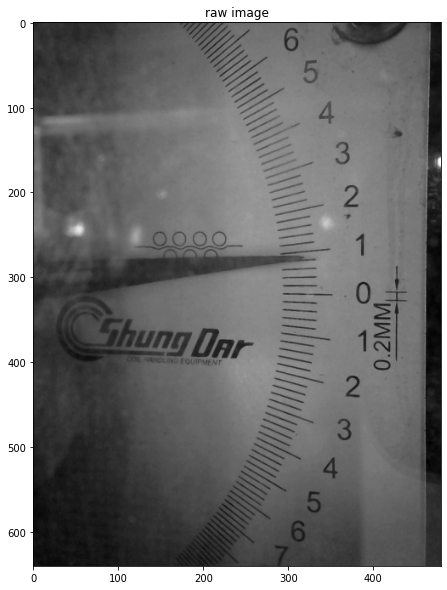

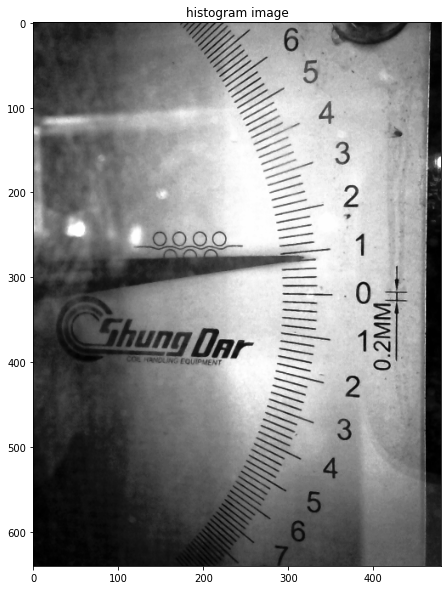

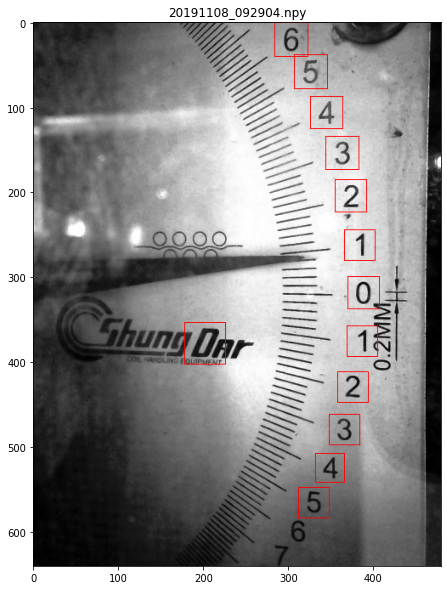

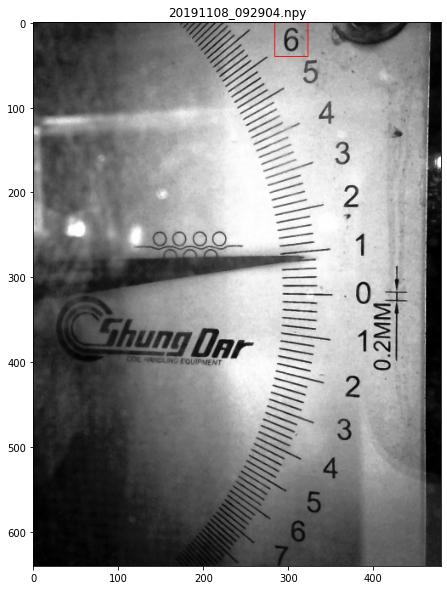

the number is  6


20191101_092904.npy


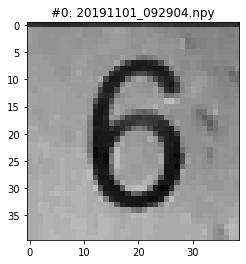

20191101_102904.npy


20191101_115303.npy


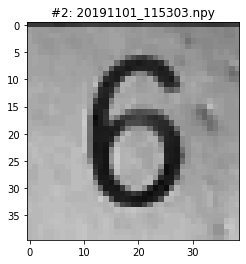

20191101_122604.npy


20191101_134204.npy


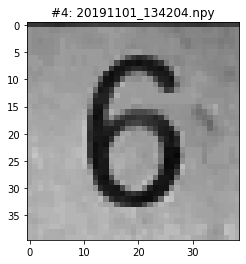

20191101_142304.npy


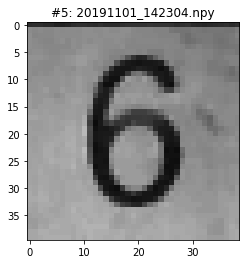

20191101_152404.npy


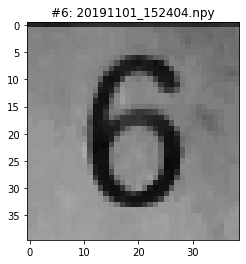

20191101_161204.npy


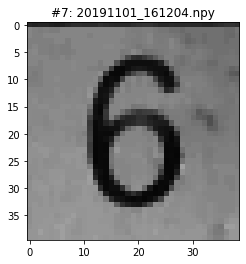

20191101_173504.npy


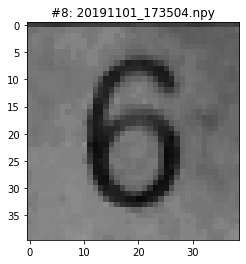

20191102_094204.npy


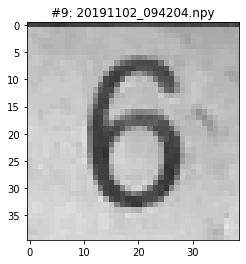

20191102_101204.npy


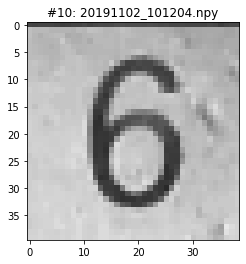

20191102_113304.npy


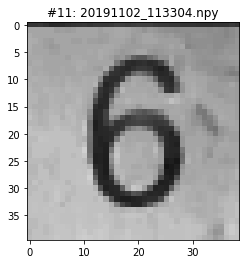

20191102_125505.npy


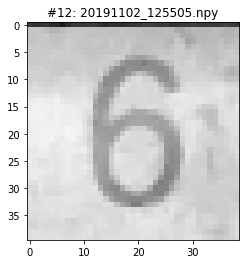

20191102_134704.npy


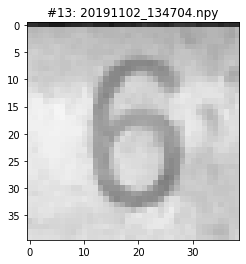

20191102_144804.npy


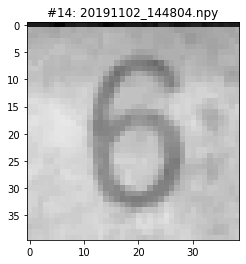

20191102_151504.npy


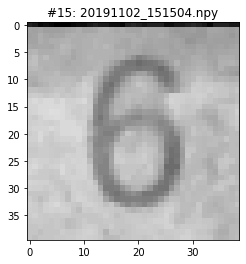

20191102_164804.npy


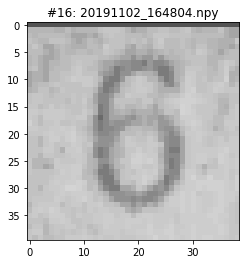

20191102_174204.npy


20191103_095304.npy


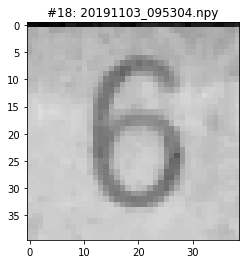

20191103_104104.npy


20191103_111804.npy


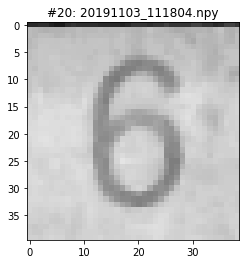

20191103_121304.npy


20191103_134604.npy


20191103_144404.npy


20191103_153204.npy


20191103_163704.npy


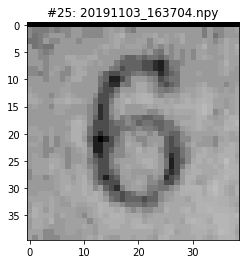

20191103_174905.npy


20191104_090204.npy


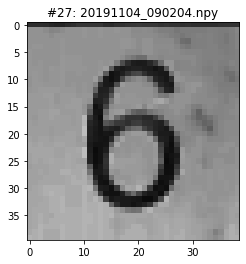

20191104_103704.npy


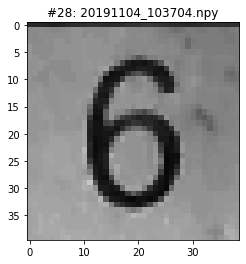

20191104_114204.npy


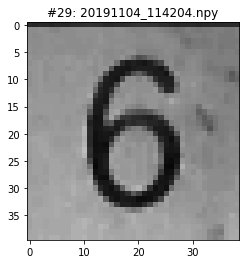

20191104_122804.npy


20191104_132204.npy


20191104_144504.npy


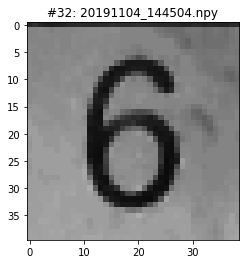

20191104_150204.npy


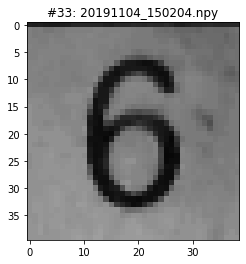

20191104_161704.npy


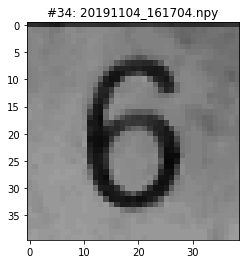

20191104_172604.npy


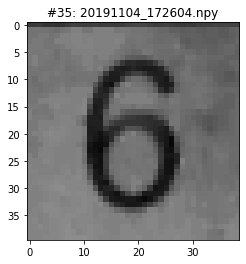

20191105_091204.npy


20191105_104904.npy


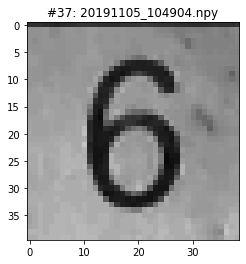

20191105_113204.npy


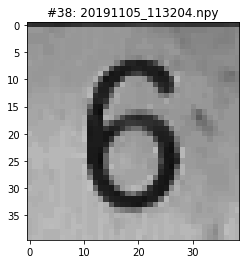

20191105_121904.npy


20191105_133304.npy


20191105_140204.npy


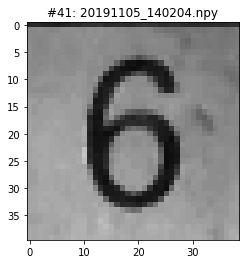

20191105_155204.npy


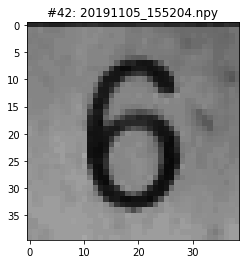

20191105_165204.npy


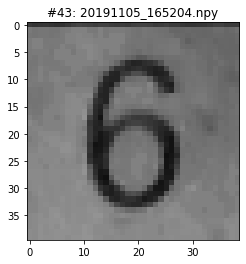

20191105_175504.npy


20191106_093704.npy


20191106_100004.npy


20191106_114004.npy


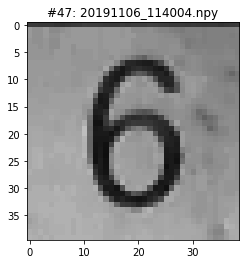

20191106_122404.npy


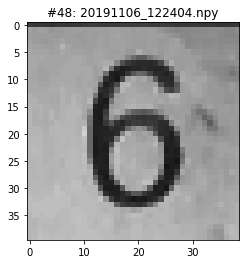

20191106_134604.npy


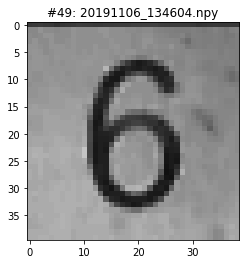

20191106_143403.npy


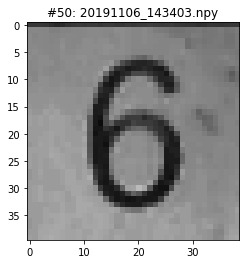

20191106_154204.npy


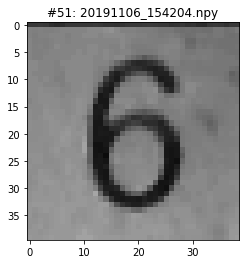

20191106_162604.npy


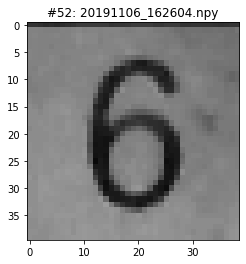

20191106_174004.npy


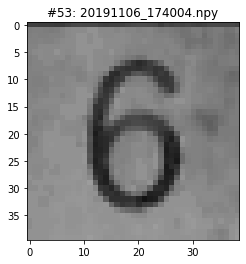

20191107_092904.npy


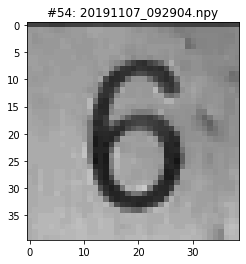

20191107_101704.npy


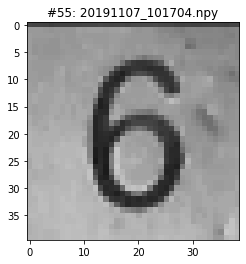

20191107_111304.npy


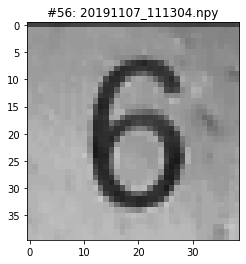

20191107_124904.npy


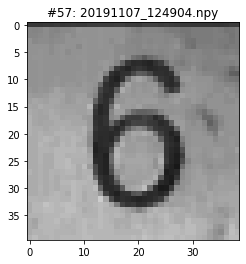

20191107_133204.npy


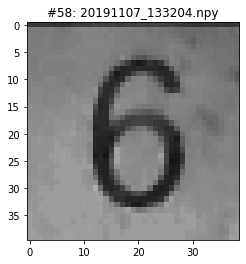

20191107_143704.npy


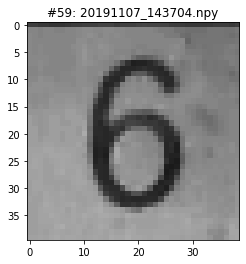

20191107_152204.npy


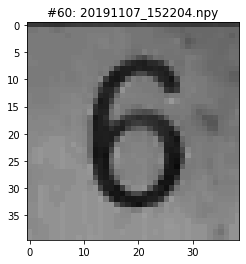

20191107_165504.npy


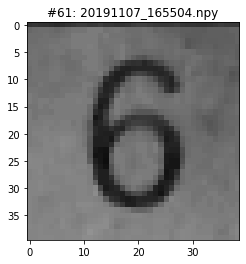

20191107_170504.npy


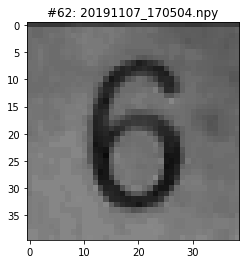

20191108_094904.npy


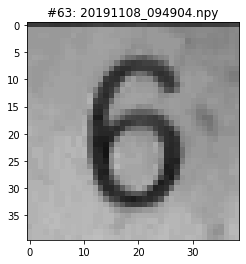

20191108_100304.npy


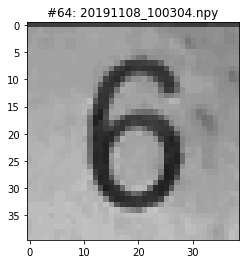

20191108_113604.npy


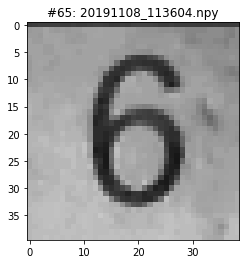

20191108_120704.npy


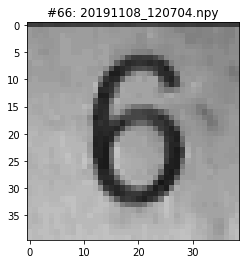

20191108_131104.npy


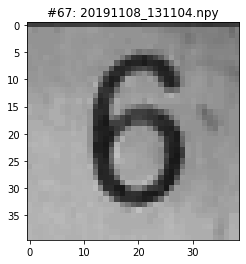

20191108_141003.npy


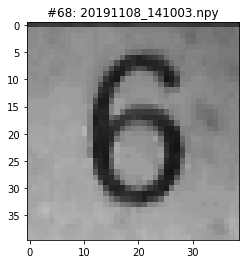

20191108_154504.npy


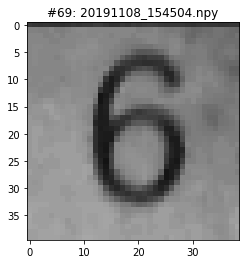

20191108_162804.npy


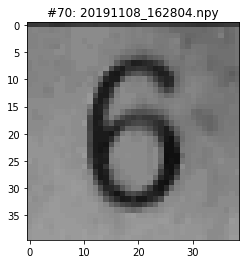

20191108_172804.npy


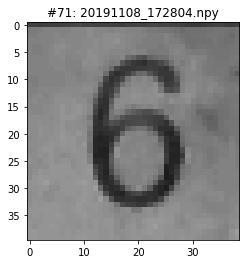

20191109_092204.npy


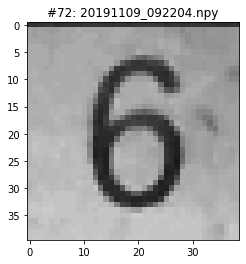

20191109_103803.npy


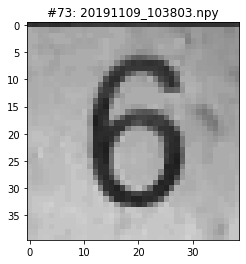

20191109_112604.npy


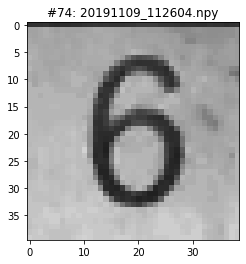

20191109_125804.npy


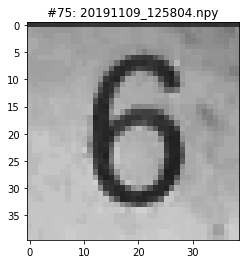

20191109_133804.npy


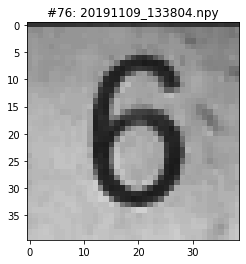

20191109_142604.npy


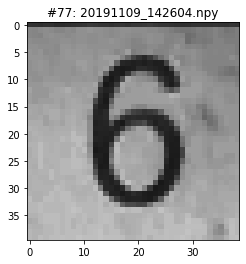

20191109_153204.npy


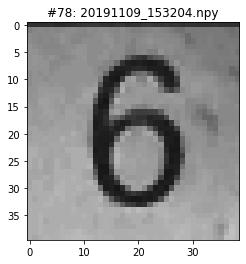

20191109_160304.npy


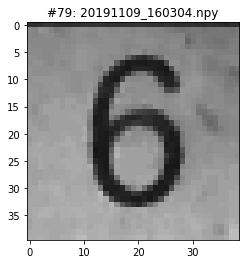

20191109_173904.npy


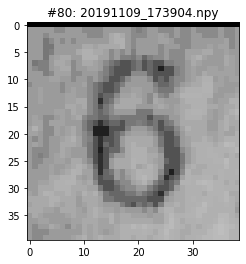

20191110_095904.npy


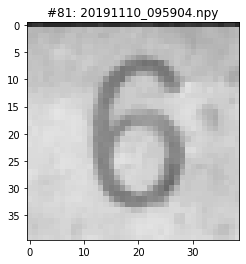

20191110_104404.npy


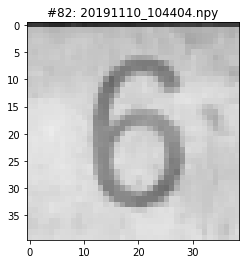

20191110_111805.npy


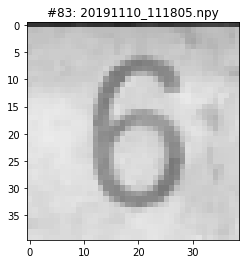

20191110_121104.npy


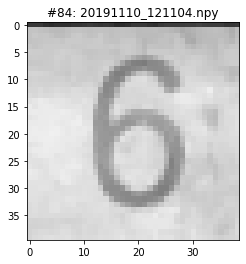

20191110_131504.npy


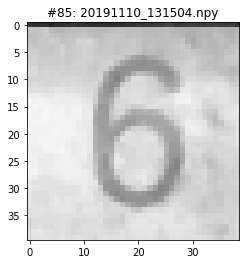

20191110_144504.npy


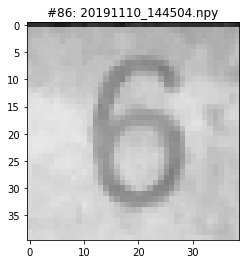

20191110_154105.npy


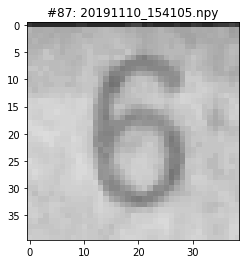

20191110_161804.npy


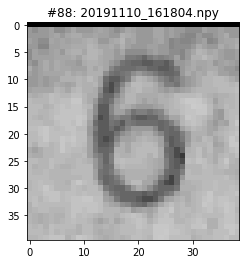

20191110_172104.npy


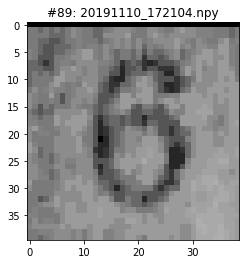

20191111_092303.npy


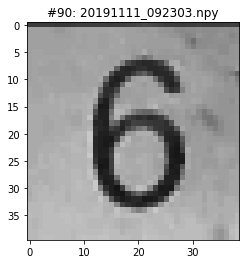

20191111_105704.npy


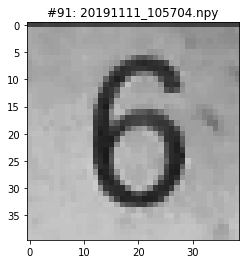

20191111_114004.npy


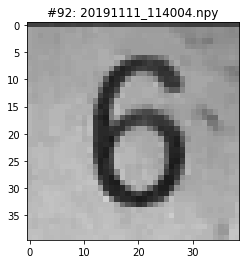

20191111_120204.npy


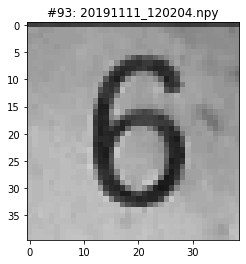

20191111_133404.npy


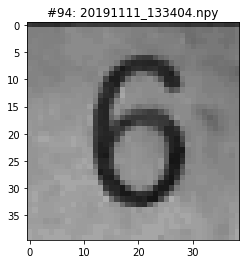

20191111_140604.npy


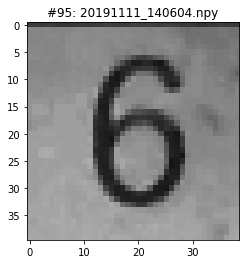

20191111_155504.npy


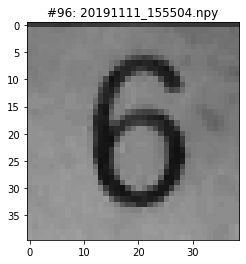

20191111_160704.npy


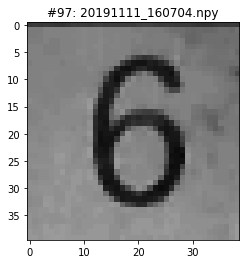

20191111_173404.npy


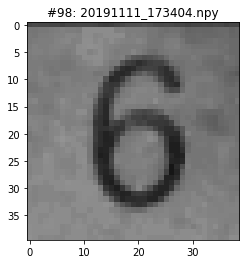

20191112_092404.npy


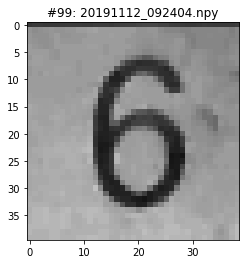

20191112_104304.npy


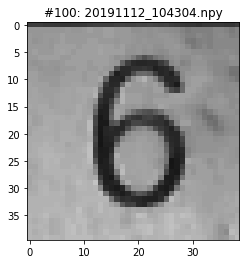

20191112_110204.npy


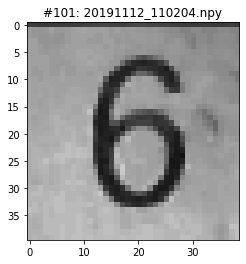

20191112_124904.npy


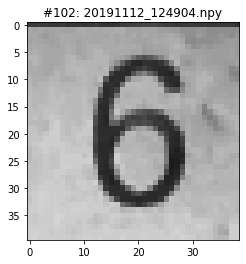

20191112_131004.npy


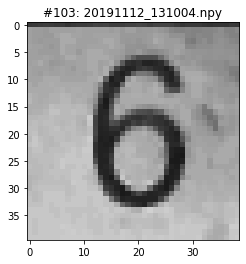

20191112_144304.npy


20191112_155904.npy


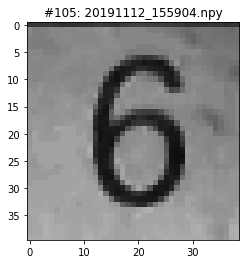

20191112_161904.npy


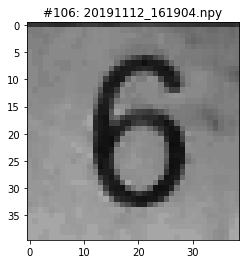

20191112_175704.npy


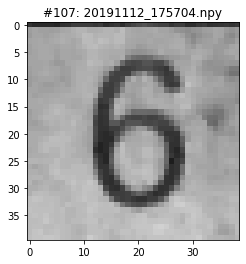

20191113_093904.npy


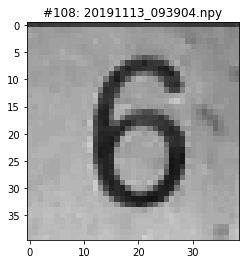

20191113_102304.npy


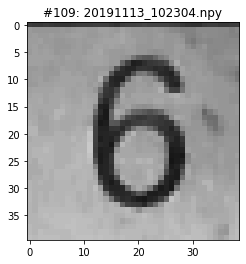

20191113_112004.npy


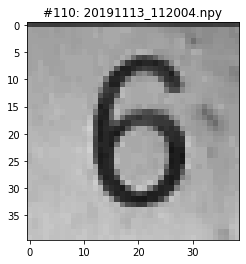

20191113_122004.npy


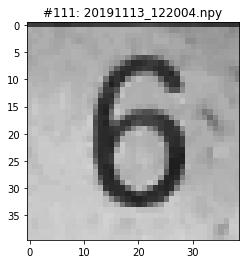

20191113_132504.npy


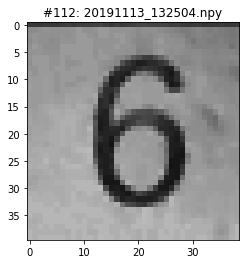

20191113_141304.npy


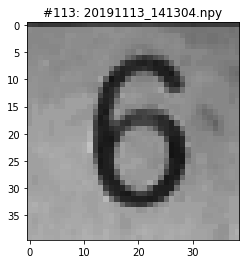

20191113_150604.npy


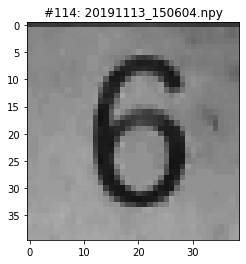

20191113_160104.npy


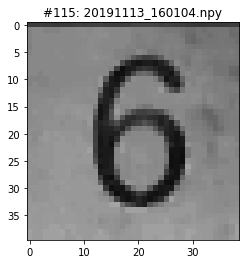

20191113_171404.npy


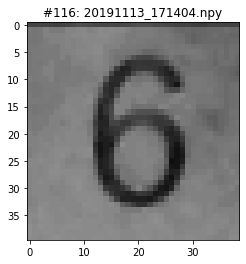

20191114_091803.npy


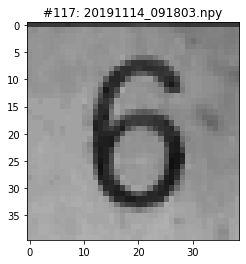

20191114_105704.npy


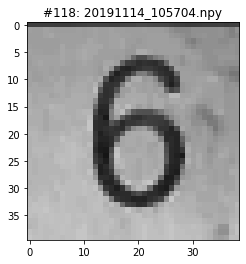

20191114_111404.npy


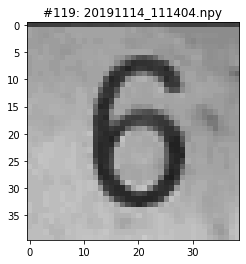

20191114_120204.npy


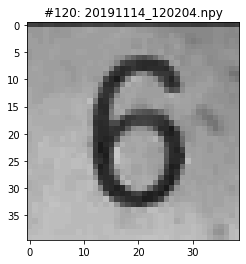

20191114_132204.npy


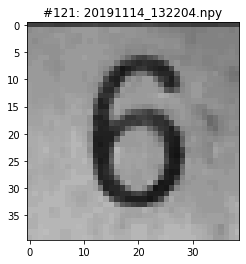

20191114_145604.npy


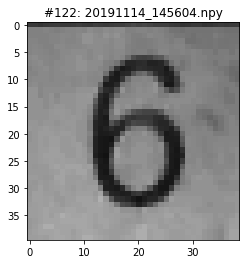

20191114_154504.npy


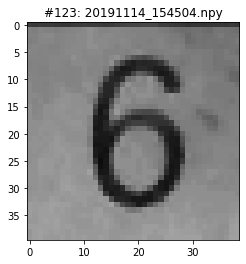

20191114_165804.npy


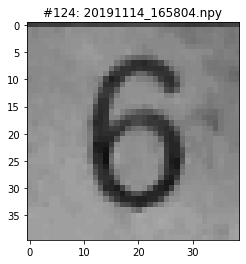

20191114_172504.npy


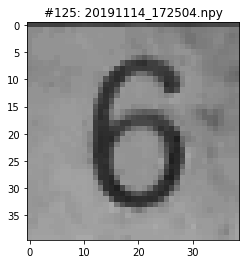

20191115_095603.npy


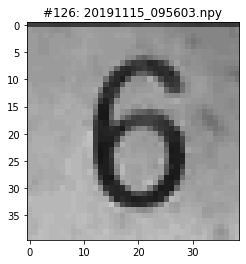

20191115_102204.npy


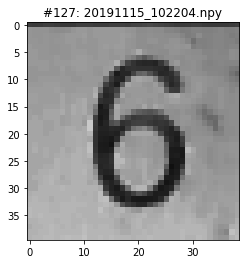

20191115_115204.npy


20191115_124404.npy


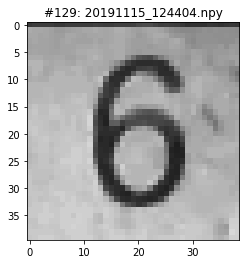

20191115_132704.npy


20191115_145504.npy


20191115_150104.npy


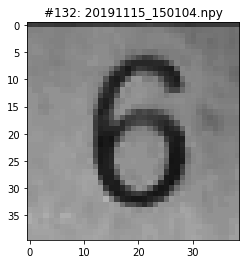

20191115_161504.npy


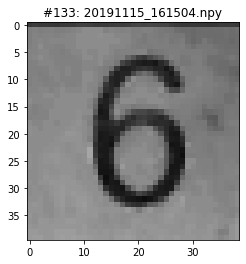

20191115_170004.npy


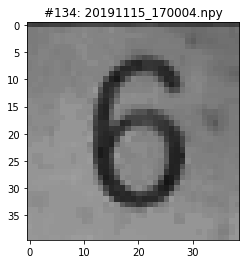

20191116_094304.npy


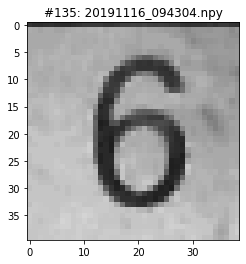

20191116_102004.npy


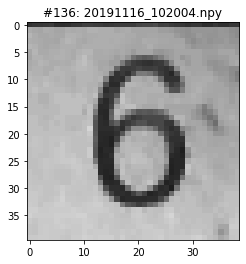

20191116_112204.npy


20191116_121204.npy


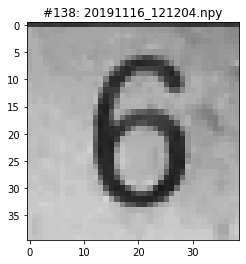

20191116_131504.npy


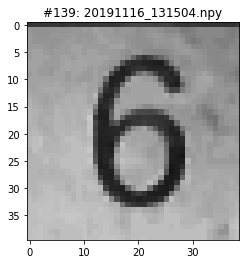

20191116_145304.npy


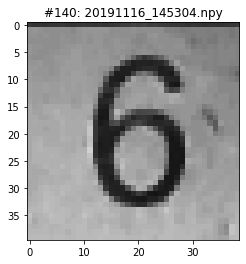

20191116_150204.npy


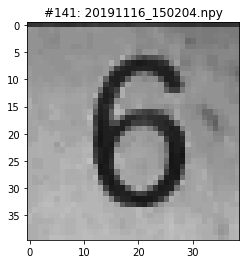

20191116_164604.npy


20191116_170205.npy


20191117_092004.npy


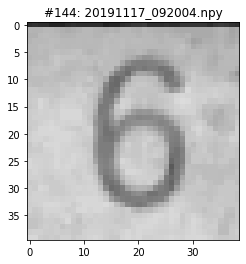

20191117_104704.npy


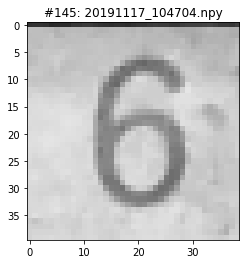

20191117_112804.npy


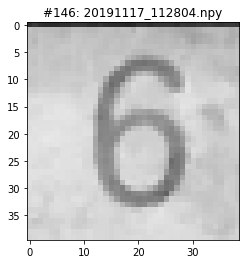

20191117_124804.npy


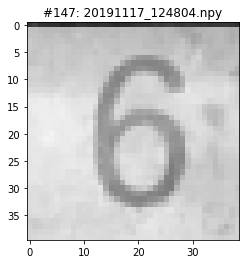

20191117_135804.npy


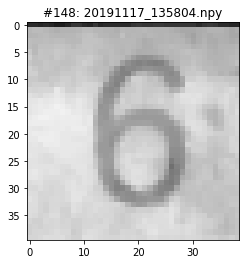

20191117_143804.npy


20191117_152704.npy


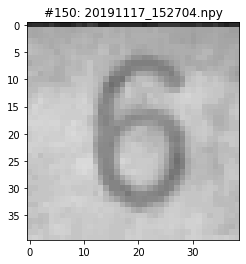

20191117_161804.npy


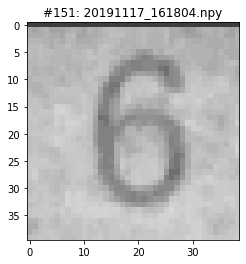

20191117_171504.npy


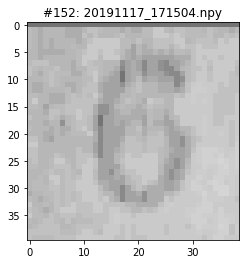

20191118_091904.npy


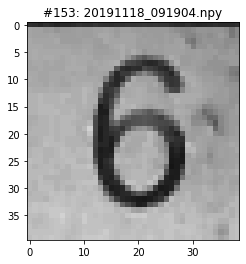

20191118_100403.npy


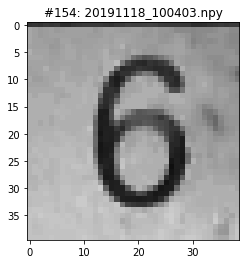

20191118_114303.npy


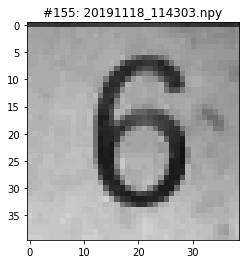

20191118_125204.npy


20191118_134104.npy


20191118_140403.npy


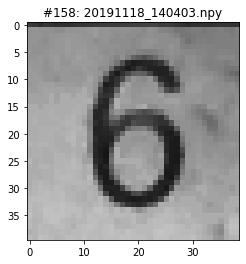

20191118_154204.npy


20191118_161604.npy


20191118_172704.npy


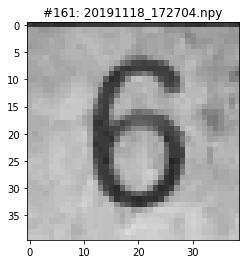

20191119_095103.npy


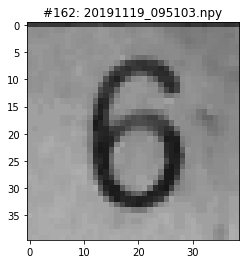

20191119_104104.npy


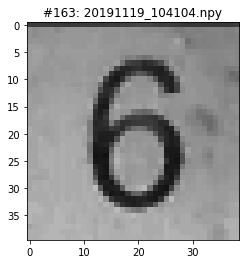

20191119_113104.npy


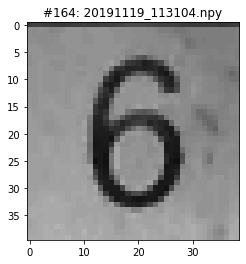

20191119_123503.npy


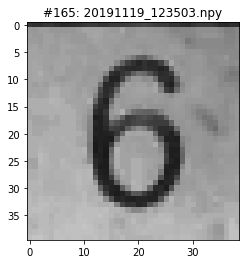

20191119_133703.npy


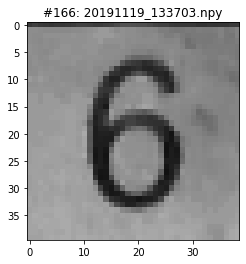

20191119_145104.npy


20191119_154304.npy


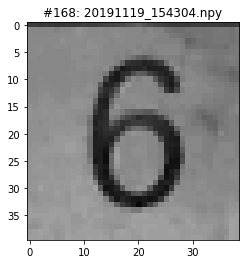

20191119_165404.npy


20191119_170204.npy


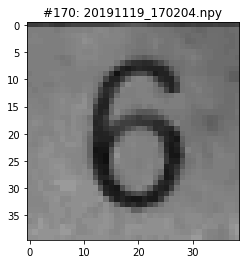

20191120_091604.npy


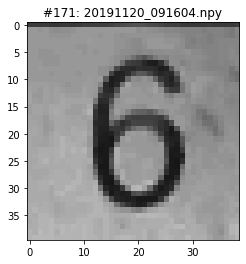

20191120_103204.npy


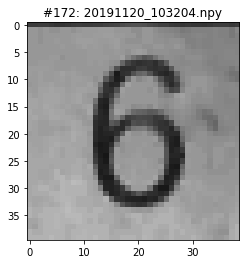

20191120_111803.npy


20191120_121504.npy


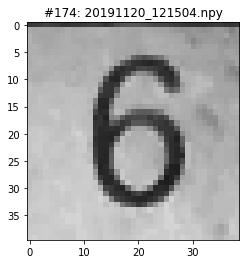

20191120_133304.npy


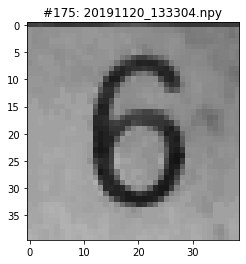

20191120_145004.npy


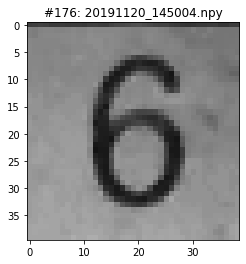

20191120_151303.npy


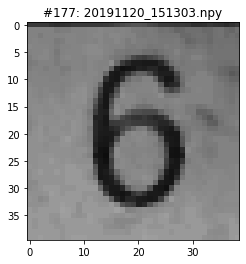

20191120_165304.npy


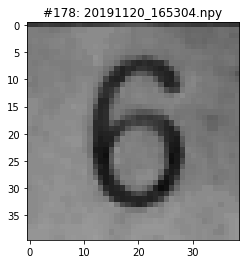

20191120_175304.npy


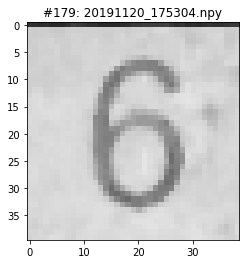

20191121_090804.npy


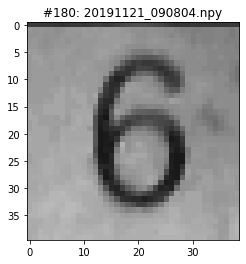

20191121_101804.npy


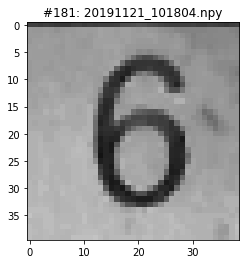

20191121_115004.npy


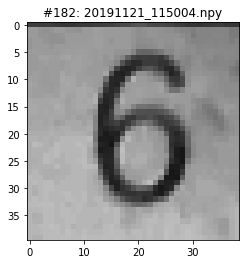

20191121_123104.npy


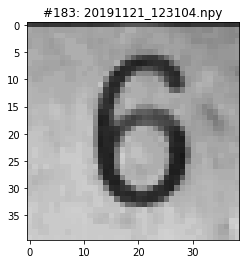

20191121_133704.npy


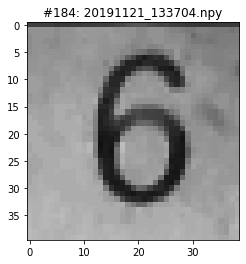

20191121_144304.npy


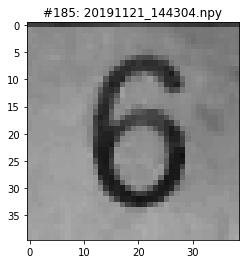

20191121_155204.npy


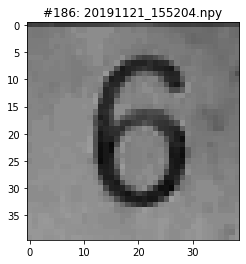

20191121_165904.npy


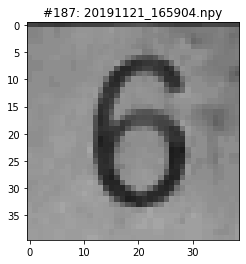

20191121_174904.npy


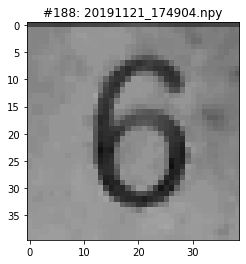

20191122_091804.npy


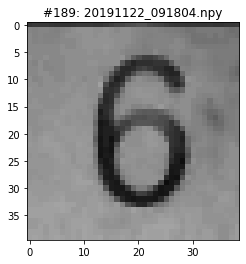

20191122_103404.npy


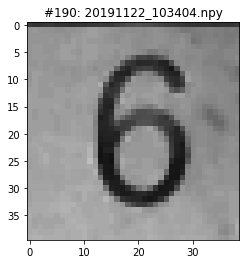

20191122_111903.npy


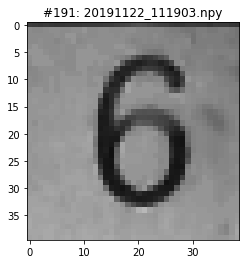

20191122_120504.npy


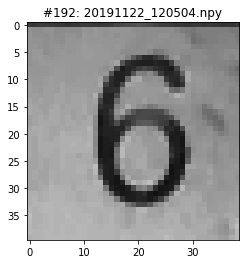

20191122_132604.npy


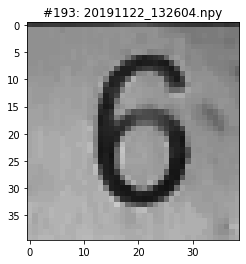

20191122_143504.npy


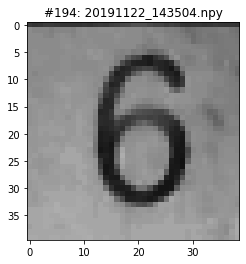

20191122_154904.npy


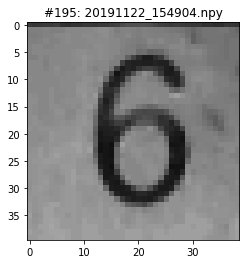

20191122_160804.npy


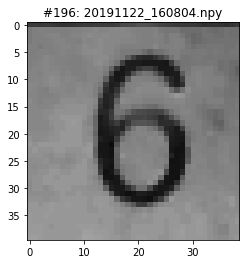

20191122_171804.npy


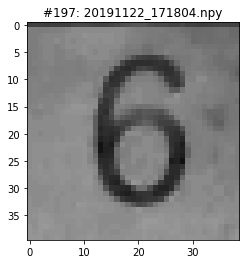

20191123_094604.npy


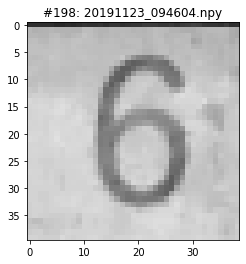

20191123_103405.npy


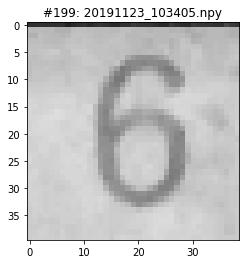

20191123_113005.npy


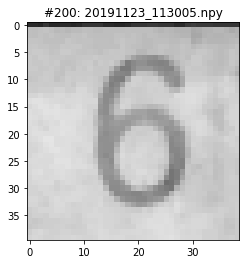

20191123_121804.npy


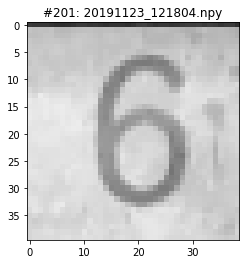

20191123_134104.npy


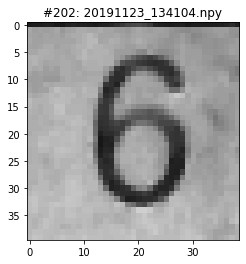

20191123_143504.npy


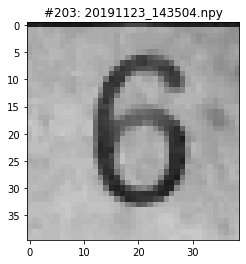

20191123_150804.npy


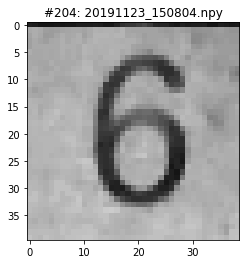

20191123_165304.npy


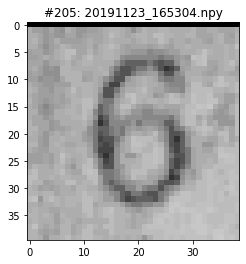

20191123_171704.npy


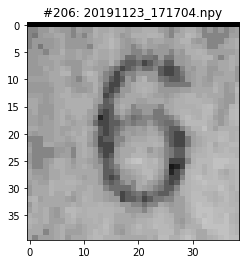

20191124_090104.npy


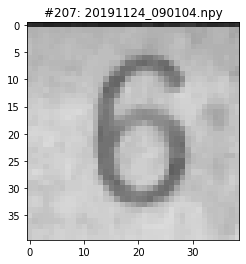

20191124_102105.npy


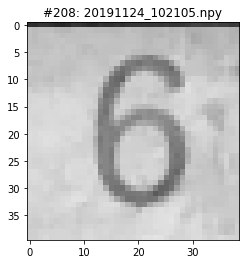

20191124_112604.npy


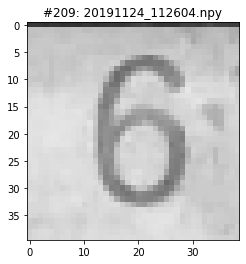

20191124_124204.npy


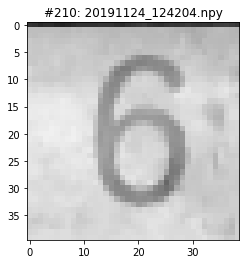

20191124_130505.npy


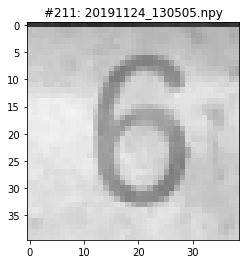

20191124_141505.npy


20191124_150104.npy


20191124_164804.npy


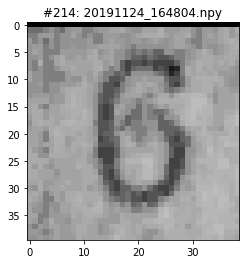

20191124_172204.npy


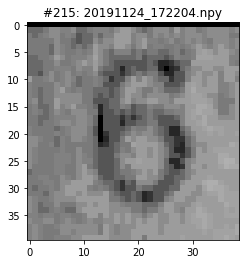

20191125_093103.npy


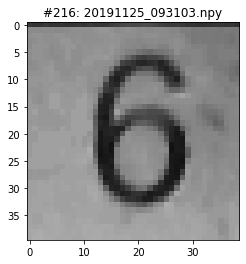

20191125_104604.npy


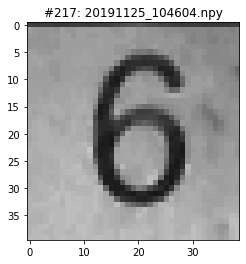

20191125_111604.npy


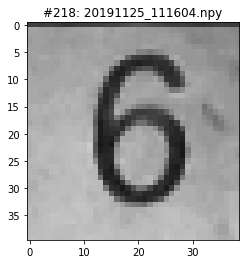

20191125_122004.npy


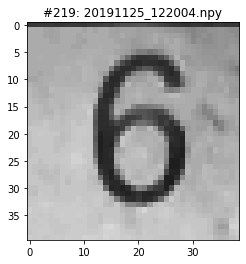

20191125_130605.npy


20191125_145604.npy


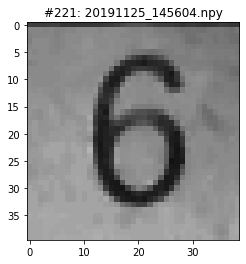

20191125_152204.npy


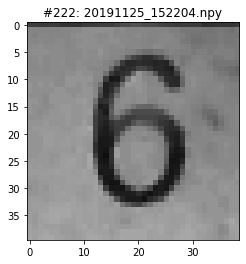

20191125_160504.npy


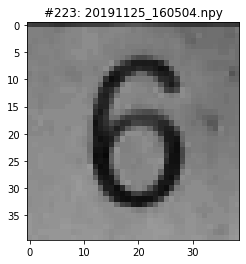

ValueError: 'a' cannot be empty unless no samples are taken

In [3]:
# 選取一張圖片，然後找出 box 位置，之後便用此位置來做標記

### 讀取圖片
img_path = '/home/shared_documents/P2019_LEVELING/Dataset/daily/daily_right/'

# 先讀一張圖進來
tar_img_filename = '20191108_092904.npy'
img = np.load(os.path.join(img_path, tar_img_filename))
img_rotated = np.empty([img.shape[1],img.shape[0]])
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_rotated[j][i]=img[i][-j]
img_rotated = img_rotated.astype(np.uint8)
frames = img_rotated

# 畫圖看一下
plt.figure(figsize=(10, 10))
plt.imshow(frames, cmap='gray')
plt.title('raw image')

# 灰階直方圖均化
frames_hist = histogram([frames], 0)

# 畫圖看一下
plt.figure(figsize=(10, 10))
plt.imshow(frames_hist, cmap='gray')
plt.title('histogram image')

# 找出所有可能的輪廓
contour_objs = find_obj_contours(frames_hist, canny_param1=100, canny_param2=500)

# 畫圖看一下
obs_frame = observe_each_frame_cnts(
    frames_hist,
    contour_objs)

# 可能的輪廓 - 篩
nonpt_cnts = get_larger_area(contour_objs, area_lb=100)

# # 畫圖看一下
# obs_frame = observe_each_frame_cnts(frames_hist, nonpt_cnts)

# 找出能圍住數字的框框
box_pos, num_contour = get_numberlike_contours(frames_hist, nonpt_cnts)

# 把數字框畫出來看一看
tar_frame = np_gray2rgb(frames_hist)
for each_box_pos in box_pos:
    cv2.rectangle(
        tar_frame, 
        (each_box_pos[0], each_box_pos[2]), 
        (each_box_pos[1], each_box_pos[3]),
        (255, 0, 0),
        1)
plt.figure(figsize=(10, 10))
plt.imshow(tar_frame)
plt.title(tar_img_filename)

# 把 box 的影像抓出來
# 把數字框畫出來看一看
tar_frame = np_gray2rgb(frames_hist)
each_box_pos = box_pos[12]    # <= *** 修改此數字來抓不同的位置 ***
cv2.rectangle(
    tar_frame, 
    (each_box_pos[0], each_box_pos[2]), 
    (each_box_pos[1], each_box_pos[3]),
    (255, 0, 0),
    1)
plt.figure(figsize=(10, 10))
plt.imshow(tar_frame)
plt.title(tar_img_filename)
plt.show()

label_str = input('the number is ')
label = int(label_str)

sample_idx = 0
img_data = []
for date_num in np.arange(1, 31):
    for hr_num in np.arange(9, 18):
        
        date_str = '{:02}'.format(date_num)
        hr_str = '{:02}'.format(hr_num)

        # 讀一張圖進來
        cand_imgs = [x for x in os.listdir(img_path) 
                     if '201911' + date_str + '_' + hr_str in x]
        tar_img_filename = np.random.choice(cand_imgs, 1)[0]
        img = np.load(os.path.join(img_path, tar_img_filename))
        print(tar_img_filename)
        
        # 旋轉
        img_rotated = np.empty([img.shape[1],img.shape[0]])
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                img_rotated[j][i]=img[i][-j]
        img_rotated = img_rotated.astype(np.uint8)
        frames = img_rotated
        
        # 灰階直方圖均化
        frames_hist = histogram([frames], 0)
        
        # 切割
        num_box = frames_hist[
            each_box_pos[2]:each_box_pos[3],
            each_box_pos[0]:each_box_pos[1]]
        
        num_box_rgb = np_gray2rgb(num_box)
        plt.figure()
        plt.imshow(num_box_rgb)
        plt.title('#{}: {}'.format(str(sample_idx), tar_img_filename))
        plt.show()
        
        img_data.append(num_box)
        sample_idx = sample_idx + 1
    

In [4]:
# 移除不好的影像樣本

bad_idx = [17, 26, 89, 152, 205, 206, 214, 215]

rev_img_data = [x for idx, x in enumerate(img_data) if idx not in bad_idx]

In [5]:
len(rev_img_data)

216

In [6]:
# 存檔
with open('six_2.pkl', 'wb') as f:
    pickle.dump(rev_img_data, f)